In [26]:
"""Much of this code from the excellent https://github.com/higgsfield/RL-Adventure"""
import math, random
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np

import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F


import seaborn as sns


import sys
if "../../" not in sys.path:
  sys.path.append("../../") 

import collections
import torch.nn as nn

from  collections  import deque
%matplotlib inline

from IPython.display import clear_output

USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


In [27]:
class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)

In [155]:
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, use_cuda, std_init=0.15):
        super(NoisyLinear, self).__init__()
        
        self.use_cuda     = use_cuda
        self.in_features  = in_features
        self.out_features = out_features
        self.std_init     = std_init
        
        self.weight_mu    = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.FloatTensor(out_features, in_features))
        
        self.bias_mu    = nn.Parameter(torch.FloatTensor(out_features))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(out_features))
        self.register_buffer('bias_epsilon', torch.FloatTensor(out_features))
        
        self.reset_parameters()
        self.reset_noise()
    
    def forward(self, x):
        if self.use_cuda:
            weight_epsilon = self.weight_epsilon.cuda()
            bias_epsilon   = self.bias_epsilon.cuda()
        else:
            weight_epsilon = self.weight_epsilon
            bias_epsilon   = self.bias_epsilon
            
        if self.training: 
            weight = self.weight_mu + self.weight_sigma.mul(Variable(weight_epsilon))
            bias   = self.bias_mu   + self.bias_sigma.mul(Variable(bias_epsilon))
        else:
            weight = self.weight_mu
            bias   = self.bias_mu
        
        return F.linear(x, weight, bias)
    
    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.weight_mu.size(1))
        
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.weight_sigma.size(1)))
        
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.bias_sigma.size(0)))
    
    def reset_noise(self):
        epsilon_in  = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(self._scale_noise(self.out_features))
    
    def _scale_noise(self, size):
        x = torch.randn(size)
        x = x.sign().mul(x.abs().sqrt())
        return x

In [156]:
class RainbowDQN(nn.Module):
    def __init__(self, num_inputs, num_actions, num_atoms, Vmin, Vmax):
        super(RainbowDQN, self).__init__()
        
        self.num_inputs   = num_inputs
        self.num_actions  = num_actions
        self.num_atoms    = num_atoms
        self.Vmin         = Vmin
        self.Vmax         = Vmax
        
        self.linear1 = nn.Linear(num_inputs, 32)
        self.linear2 = nn.Linear(32, 64)
        
        self.noisy_value1 = NoisyLinear(64, 64, use_cuda=USE_CUDA)
        self.noisy_value2 = NoisyLinear(64, self.num_atoms, use_cuda=USE_CUDA)
        
        self.noisy_advantage1 = NoisyLinear(64, 64, use_cuda=USE_CUDA)
        self.noisy_advantage2 = NoisyLinear(64, self.num_atoms * self.num_actions, use_cuda=USE_CUDA)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        
        value = F.relu(self.noisy_value1(x))
        value = self.noisy_value2(value)
        
        advantage = F.relu(self.noisy_advantage1(x))
        advantage = self.noisy_advantage2(advantage)
        
        value     = value.view(batch_size, 1, self.num_atoms)
        advantage = advantage.view(batch_size, self.num_actions, self.num_atoms)
        
        
        x = value + advantage - advantage.mean(1, keepdim=True)
        x = F.softmax(x.view(-1, self.num_atoms)).view(-1, self.num_actions, self.num_atoms)
        
        return x
        
    def reset_noise(self):
        self.noisy_value1.reset_noise()
        self.noisy_value2.reset_noise()
        self.noisy_advantage1.reset_noise()
        self.noisy_advantage2.reset_noise()
    
    def act(self, state):
        state = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
        dist = self.forward(state).data.cpu()
        dist = dist * torch.linspace(self.Vmin, self.Vmax, self.num_atoms)
        action = dist.sum(2).max(1)[1].numpy()[0]
        return action

In [157]:
def projection_distribution(next_state, rewards, dones):
    batch_size  = next_state.size(0)
    
    delta_z = float(Vmax - Vmin) / (num_atoms - 1)
    support = torch.linspace(Vmin, Vmax, num_atoms)
    
    next_dist   = target_model(next_state).data.cpu() * support
    next_action = next_dist.sum(2).max(1)[1]
    next_action = next_action.unsqueeze(1).unsqueeze(1).expand(next_dist.size(0), 1, next_dist.size(2))
    next_dist   = next_dist.gather(1, next_action).squeeze(1)
        
    rewards = rewards.unsqueeze(1).expand_as(next_dist)
    dones   = dones.unsqueeze(1).expand_as(next_dist)
    support = support.unsqueeze(0).expand_as(next_dist)
    
    Tz = rewards + (1 - dones) * 0.99 * support
    Tz = Tz.clamp(min=Vmin, max=Vmax)
    b  = (Tz - Vmin) / delta_z
    l  = b.floor().long()
    u  = b.ceil().long()
        
    offset = torch.linspace(0, (batch_size - 1) * num_atoms, batch_size).long()\
                    .unsqueeze(1).expand(batch_size, num_atoms)

    proj_dist = torch.zeros(next_dist.size())    
    proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1))
    proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1))
        
    return proj_dist

In [158]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. 
                                                                * frame_idx / epsilon_decay)

In [159]:
class Market(gym.Env):
    def __init__(self, kappa, episodes, time_periods, mu, r, sigma, inv_range):

        self.episodes = episodes
        self.time_periods = time_periods
        self.epi = 0
        self.t = 0

        self.inv_range = inv_range

        self.mu = mu
        self.r = r
        self.sigma = sigma

        self._start_wealth = 100.0
        self.kappa = kappa

        self.action_space = spaces.Discrete(len(inv_range))
        self.observation_space = spaces.Box(0,120, np.array([2]))
        
        self.seed()
        self.viewer = None
        self.state = None

        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def reset(self):
        self.S, self.B, self.dS, self.dB = self.generate_price_series()
        self.wealth = self._start_wealth
        #self.state = (int(self.S[self.t,self.epi]*100),int(self._start_wealth/10))
        
        self.state = (self.S[self.t,self.epi],self._start_wealth)
        return np.array(self.state)

    
    def step(self, action):
        
        assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
        price_state, wealth_state = self.state
        
        prop = self.inv_range[action]

        discount = 0.99

        if self.t < self.time_periods:
            NB = (1-prop)*self.wealth/self.B[self.t]
            NS = prop*self.wealth/self.S[self.t, self.epi]

            dX = NB*self.dB[self.t] +NS*self.dS[self.t,self.epi]
            reward = dX - (self.kappa/2)*(dX**2)  
            self.wealth += dX

            done = False

            #self.wealth_state = int(self.wealth/10)
            self.wealth_state = self.wealth
            self.t += 1
            
            #new_state = (int(self.S[self.t,self.epi]*100), self.wealth_state)
            
            new_state = (self.S[self.t,self.epi], self.wealth_state)
            self.state = new_state
            final_wealth = 0.0
            
        else:
            #reached the end of episode...
            self.t = 0
            self.epi = 0 #+=1

            reward = 0.0
            dX = 0.0
            final_wealth = self.wealth
            done = True

            _ = self.reset()

        return np.array(self.state), reward, done, final_wealth

    def generate_price_series(self):
        I = 1 #self.episodes
        M = self.time_periods

        S0 = 1
        B0 = 1
        T = 1.0
        dt = T/M

        mu = self.mu
        r = self.r
        sigma = self.sigma

        S = np.zeros((M+1,I))
        dS = np.zeros((M,I))
        dB = np.zeros(M)

        B = np.zeros(M+1)
        B[0] = B0
        S[0] = S0

        for t in range(1, M+1):
            z = np.random.standard_normal(I)
            #df = 10
            #z = np.random.standard_t(df,I)
            S[t] = S[t-1]*np.exp((mu-0.5*sigma**2)*dt + sigma*math.sqrt(dt)*z)
            B[t] = B[t-1]*np.exp(r*dt)

        for t in range(1,M):
            dS[t] = S[t+1] - S[t]
            dB[t] = B[t+1] - B[t]

        return S, B, dS, dB

In [160]:
kappa = 0.008
episodes = 3000000
time_periods = 20
mu =0.10
rf = 0.02
sigma = 0.20

In [161]:
episodes = episodes #500k worked well? as did 1m

utes = 15
u_star = np.linspace(0,5, utes)

Mark = Market(kappa, episodes, time_periods, mu, rf, sigma, u_star) #parameters from earlier

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [162]:
env = Mark

In [163]:
num_atoms = 51
Vmin = -10
Vmax = 10

current_model = RainbowDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)
target_model  = RainbowDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), 0.001)

replay_buffer = ReplayBuffer(10000)

In [164]:
"""
num_atoms = 51
Vmin = 0
Vmax = 120

current_model = CategoricalDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)
target_model  = CategoricalDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters())

replay_buffer = ReplayBuffer(10000)
"""

'\nnum_atoms = 51\nVmin = 0\nVmax = 120\n\ncurrent_model = CategoricalDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)\ntarget_model  = CategoricalDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)\n\nif USE_CUDA:\n    current_model = current_model.cuda()\n    target_model  = target_model.cuda()\n    \noptimizer = optim.Adam(current_model.parameters())\n\nreplay_buffer = ReplayBuffer(10000)\n'

In [165]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())
    
update_target(current_model, target_model)

In [166]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size) 

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(np.float32(done))

    proj_dist = projection_distribution(next_state, reward, done)
    
    dist = current_model(state)
    action = action.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, num_atoms)
    dist = dist.gather(1, action).squeeze(1)
    dist.data.clamp_(0.01, 0.99)
    loss = -(Variable(proj_dist) * dist.log()).sum(1)
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    current_model.reset_noise()
    target_model.reset_noise()
    
    return loss

In [167]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

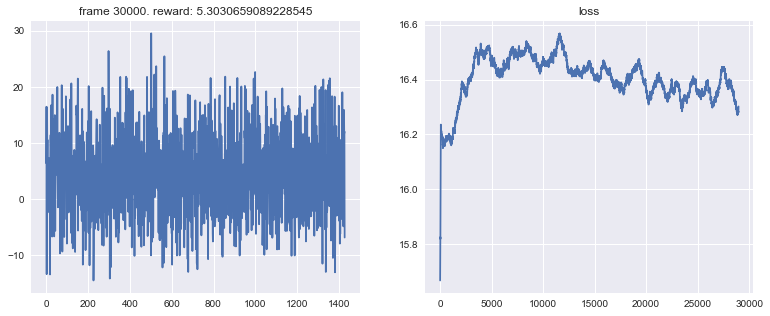

In [168]:
num_frames = 30000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    action = current_model.act(state)
    
    #print(state,action)
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.data[0])
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards
                         ,np.convolve(losses,np.ones((1000,))/1000,mode='valid'))
        
    if frame_idx % 100 == 0:
        update_target(current_model, target_model)


In [110]:
"""
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()

for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    
    action = model.act(state, epsilon) #norm
    #print(action)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        #print('here')
        loss = compute_td_loss(batch_size)
        losses.append(loss.data[0])
        
    if frame_idx % 400 == 0:
        plot(frame_idx, all_rewards
                         ,np.convolve(losses,np.ones((1000,))/1000,mode='valid'))
        
        #plt.plot(np.convolve(utilities_test_best, np.ones((10000,))/10000, mode='valid'), label='Merton Optimal')
        #plt.plot(np.convolve(utilities_test_rand, np.ones((10000,))/10000, mode='valid'), label='Random agent')
        #plt.plot(np.convolve(utilities_test, np.ones((10000,))/10000, mode='valid'), label='Trained agent')
"""

"\nnum_frames = 10000\nbatch_size = 32\ngamma      = 0.99\n\nlosses = []\nall_rewards = []\nepisode_reward = 0\n\nstate = env.reset()\n\nfor frame_idx in range(1, num_frames + 1):\n    epsilon = epsilon_by_frame(frame_idx)\n    \n    action = model.act(state, epsilon) #norm\n    #print(action)\n    \n    next_state, reward, done, _ = env.step(action)\n    replay_buffer.push(state, action, reward, next_state, done)\n    \n    state = next_state\n    episode_reward += reward\n    \n    if done:\n        state = env.reset()\n        all_rewards.append(episode_reward)\n        episode_reward = 0\n        \n    if len(replay_buffer) > batch_size:\n        #print('here')\n        loss = compute_td_loss(batch_size)\n        losses.append(loss.data[0])\n        \n    if frame_idx % 400 == 0:\n        plot(frame_idx, all_rewards\n                         ,np.convolve(losses,np.ones((1000,))/1000,mode='valid'))\n        \n        #plt.plot(np.convolve(utilities_test_best, np.ones((10000,))/10000

In [119]:
episodes = 100001
wealth = 100.0
utilities_mod = []
rewards_mod = []
step_rewards = []
rsum = 0
wealth_episodes = []
number_of_actions = utes

Mark1 = Market(kappa, episodes, time_periods, mu, rf, sigma, u_star)


for i_episode in range(episodes-1):

    if i_episode%10000 ==0:
        print(i_episode)
        
    state = Mark1.reset() 
    action = current_model.act(state)
    #action = model(Variable(torch.FloatTensor(np.float32(state)))).argmax().item()

    while True:    
        new_state , reward, done, final_wealth = Mark.step(action) #(prop, wealth))
        #action = model(Variable(torch.FloatTensor(np.float32(new_state)))).argmax().item()
        action = current_model.act(state)
        rsum += reward
        state = new_state

        #print(new_state)
        #print(model(Variable(torch.FloatTensor(np.float32(new_state)))))
        step_rewards.append(reward)

        if done:
            wealth_episodes.append(final_wealth)
            utilities_mod.append(np.log(final_wealth))
            rewards_mod.append(rsum)
            rsum = 0
            #wealth = 100.0
            #print(i_episode, final_wealth)
            break 


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
0


/Users/johngoodacre/anaconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/Users/johngoodacre/anaconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


10000
20000
30000
40000
50000
60000
70000
80000
90000


In [120]:
utilities_test = utilities_mod
rewards_test = rewards_mod
step_rew_test = step_rewards
wealth_test = wealth_episodes

In [121]:
from lib.sim_prices import make_prices
from lib.execute_strat import execute_strat
from lib.graphs import make_baseline_graphs, make_agent_graphs, plot_sample_paths, plot_disc_utility, \
                        plot_mv_equiv, plot_const_step

In [122]:
#episodes = 99##3000000
#Q, utilities_mod, rewards_mod, wealth_episodes = train_agent(kappa, episodes)

def make_agent_graphs_new(rewards_test_best, rewards_test_rand, rewards_test,
                      utilities_test_best, utilities_test_rand, utilities_test,
                     wealth_test_rand, wealth_test_best, wealth_test):

    block_utilities_test = np.mean(np.array(utilities_test).reshape(1000,-1),0)
    block_utilities_test_rand = np.mean(np.array(utilities_test_rand).reshape(1000,-1),0)
    block_utilities_test_best = np.mean(np.array(utilities_test_best).reshape(1000,-1),0)


    block_wealth_test_rand = np.mean(np.array(wealth_test_rand).reshape(1000,-1),0)
    block_wealth_test_best = np.mean(np.array(wealth_test_best).reshape(1000,-1),0)
    block_wealth_test = np.mean(np.array(wealth_test).reshape(1000,-1),0)


    block_rewards_test = np.mean(np.array(rewards_test).reshape(1000,-1),0)
    block_rewards_test_rand = np.mean(np.array(rewards_test_rand).reshape(1000,-1),0)
    block_rewards_test_best = np.mean(np.array(rewards_test_best).reshape(1000,-1),0)

    #Calculate sharpe ratios instead of longitudinally do it at the end blocks of 1000 again

    #mu - rf/ sigma
    wr = np.array(wealth_test_rand).reshape(100,-1)
    wr_sharpe = (wr.mean(axis=0)/100-1)/(wr.std(axis=0)/100)

    wt = np.array(wealth_test).reshape(100,-1)
    wt_sharpe = (wt.mean(axis=0)/100-1)/(wt.std(axis=0)/100)

    wb = np.array(wealth_test_best).reshape(100,-1)
    wb_sharpe = (wb.mean(axis=0)/100-1)/(wb.std(axis=0)/100)


    sns.distplot(block_rewards_test_best, label="Merton optimal")
    sns.distplot(block_rewards_test, label="Trained Agent")
    sns.distplot(block_rewards_test_rand, label="Random agent")
    plt.title('Distribution of Final rewards Merton v Trained Agent v Random (per 1000 episodes)')
    plt.xlabel('Episode Rewards')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    plt.violinplot([block_rewards_test_rand, block_rewards_test, block_rewards_test_best])
    plt.xticks([1,2,3], ["Random Agent", "Trained Agent", "Merton Optimal"], rotation=60, size=12)
    plt.ylabel("Test Rewards", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_axis_bgcolor('white')
    ax.grid(0)
    plt.title("Violin plot of Rewards - Random v Merton v Agent")
    plt.show()


    sns.distplot(block_utilities_test_best, label="Merton optimal")
    sns.distplot(block_utilities_test, label="Trained Agent")
    sns.distplot(block_utilities_test_rand, label="Random agent")
    plt.title('Distribution of Final Utilities Merton v Trained Agent v Random (per 1000 episodes)')
    plt.xlabel('Episode Utilities')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    plt.violinplot([block_utilities_test_rand, block_utilities_test, block_utilities_test_best])
    plt.xticks([1,2,3], ["Random Agent", "Trained Agent", "Merton Optimal"], rotation=60, size=12)
    plt.ylabel("Test Utility", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_axis_bgcolor('white')
    ax.grid(0)
    plt.title("Violin plot of utilities - Random v Merton v Agent")
    plt.show()

    plt.plot(np.convolve(utilities_test_best, np.ones((10000,))/10000, mode='valid'), label='Merton Optimal')
    plt.plot(np.convolve(utilities_test_rand, np.ones((10000,))/10000, mode='valid'), label='Random agent')
    plt.plot(np.convolve(utilities_test, np.ones((10000,))/10000, mode='valid'), label='Trained agent')
    plt.title('Moving average 10,000 episode utilities')
    plt.ylabel('Utility')
    plt.xlabel('Episode')
    plt.legend()
    plt.show()

    plt.violinplot([block_wealth_test_rand, block_wealth_test, block_wealth_test_best])
    plt.xticks([1,2,3], ["Random Agent", "Trained Agent", "Merton Optimal"], rotation=60, size=12)
    plt.ylabel("Test Wealth", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_axis_bgcolor('white')
    ax.grid(0)
    plt.title("Violin plot of Wealth - Random v Merton v Agent")
    plt.show()


    sns.distplot(block_wealth_test_best, label="Merton optimal")
    sns.distplot(block_wealth_test, label="Trained Agent")
    sns.distplot(block_wealth_test_rand, label="Random agent")
    plt.title('Distribution of Final Wealth Merton v Trained Agent v Random (per 1000 episodes)')
    plt.xlabel('Episode Wealth')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    plt.violinplot([wr_sharpe, wt_sharpe, wb_sharpe])
    plt.xticks([1,2,3], ["Random Agent", "Trained Agent", "Merton Optimal"], rotation=60, size=12)
    plt.ylabel("Test Sharpe", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_axis_bgcolor('white')
    ax.grid(0)
    plt.title("Violin plot of Sharpe ratios (M period) - Random v Merton v Agent")
    plt.show()

    sns.distplot(wb_sharpe, label="Merton optimal")
    sns.distplot(wt_sharpe, label="Trained Agent")
    sns.distplot(wr_sharpe, label="Random agent")
    plt.title('Distribution of Final Sharpe ratios  Merton v Trained Agent v Random (per 1000 episodes)')
    plt.xlabel('Episode Sharpe')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    return block_utilities_test_rand, block_utilities_test, block_utilities_test_best, \
           block_rewards_test_rand, block_rewards_test, block_rewards_test_best, \
           block_wealth_test_rand, block_wealth_test, block_wealth_test_best, \
           wr_sharpe, wt_sharpe, wb_sharpe

In [123]:
wealth = 100.0

merton_ratio = (mu-rf)/sigma**2
best_action = np.argmin(np.abs(u_star-merton_ratio))
#temp change to execute strat
utilities_test_rand, rewards_test_rand, step_rew_rand, wealth_test_rand = execute_strat(kappa,mu, 
                                                                      rf, sigma, utes,u_star,best_action, 'Random',
                                                                      episodes=100001,
                                                                      time_periods=time_periods, wealth=wealth)
utilities_test_best, rewards_test_best, step_rew_best, wealth_test_best = execute_strat(kappa, mu, rf, sigma, 
                                                                      utes, u_star, best_action,'Merton', 
                                                                      episodes=100001,
                                                                      time_periods=time_periods, wealth=wealth)

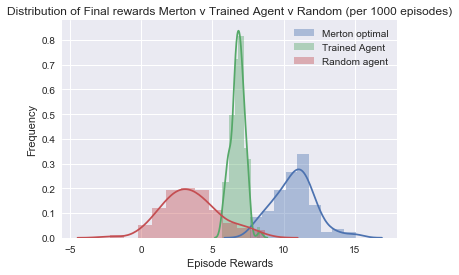

/Users/johngoodacre/anaconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


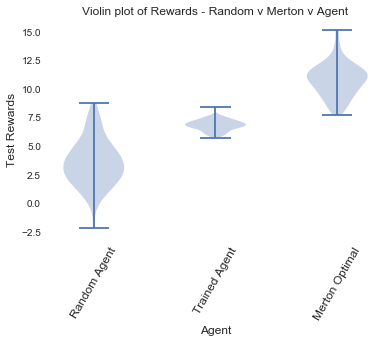

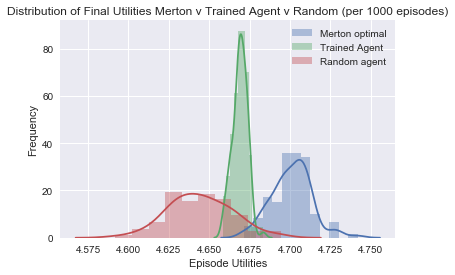

/Users/johngoodacre/anaconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


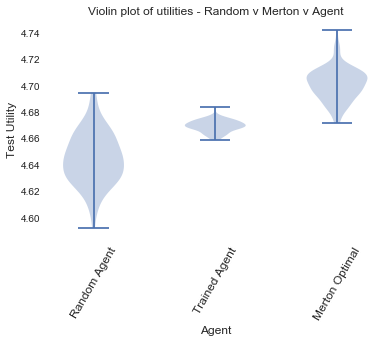

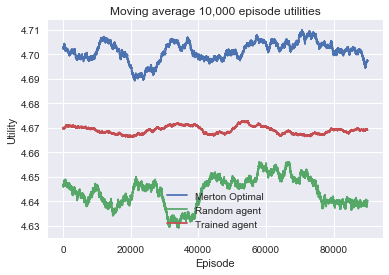

/Users/johngoodacre/anaconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


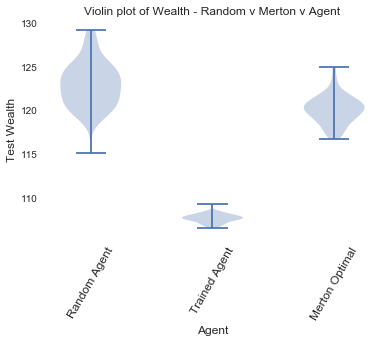

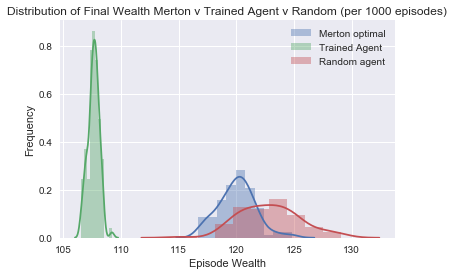

/Users/johngoodacre/anaconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:108: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


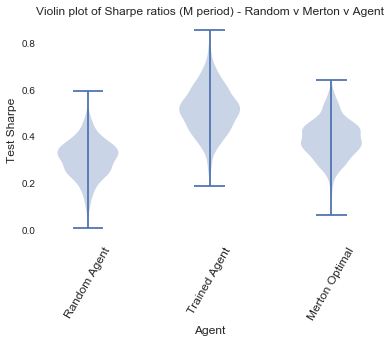

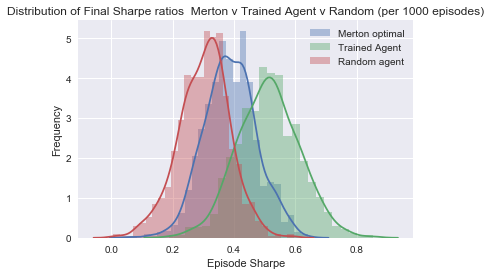

In [124]:
#utilities_test, rewards_test, step_rew_test, wealth_test = execute_strat(kappa, mu, rf, sigma, utes, u_star,best_action, 
#                                                            'Agent', q_values=Q, 
#                                                            time_periods=time_periods, wealth=wealth)

results = make_agent_graphs_new(rewards_test_best, rewards_test_rand, rewards_test,
                  utilities_test_best, utilities_test_rand, utilities_test,
                         wealth_test_rand, wealth_test_best, wealth_test)

In [125]:
for r in results:
    print(np.mean(r))

4.6444053773269465
4.668999555189598
4.70081609292992
3.514289949468414
6.768554360475732
10.742314755736686
122.87700857619404
107.62784540757782
120.05050105813001
0.3030623594037104
0.5118426394667022
0.3879059061179669


In [126]:
for r in results:
    print(np.std(r))

0.019492539913618528
0.004541264171776037
0.012377474116190789
2.0053052685489563
0.4810221201161524
1.4395357821024597
2.5856172119842227
0.4862565251998127
1.5935295463258012
0.08326658732007272
0.10069492610657514
0.0841335125213645
